# Project : CutMix 또는 Mixup 비교실험 하기

## 1. Augmentation을 적용한 데이터셋 만들기
---

### 1-1. 데이터 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


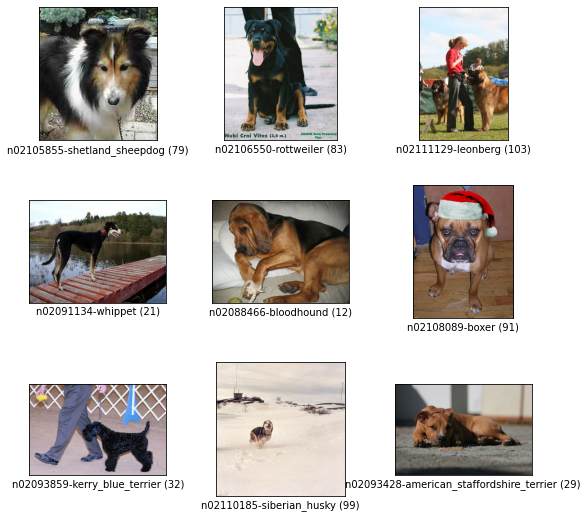

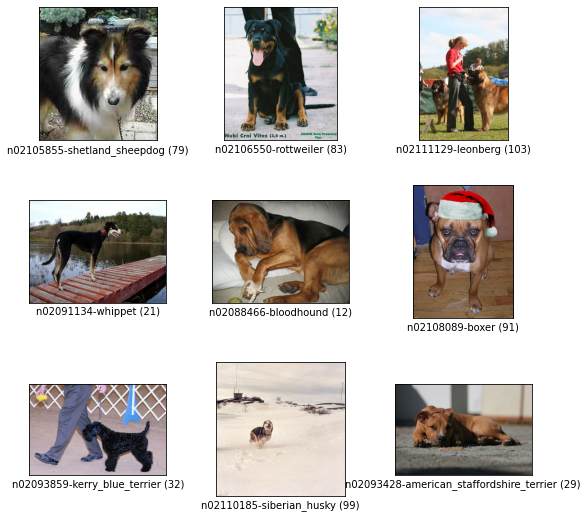

In [4]:
tfds.show_examples(ds_train, ds_info)

### 1-2. Augmentation을 적용한 데이터셋 만들기 (Cutmix Augmentation)

In [6]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [9]:
# Random Augmentation 직접 구현

def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))    # 50%의 확률로 이미지 가운데 부분을 crop합니다.
    image = tf.image.resize(image, INPUT_SHAPE)    # crop한 이미지를 원본 사이즈로 resize
    
    return image, label

In [10]:
# Augumentation 을 적용한 데이터를 학습한 모델과 적용하지 않은 데이터를 학습한 모델의 성능 비교

num_classes = ds_info.features['label'].num_classes

resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                       weights = 'imagenet', 
                                                                       input_shape = (224, 224, 3), 
                                                                       pooling = 'avg'), 
                                    keras.layers.Dense(num_classes, activation = 'softmax')])

94773248/94765736 [==============================] - 1s 0us/step


In [11]:
# Augmentation 을 적용한 데이터셋으로 학습시킬 ResNet 생성

aug_resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                          weights = 'imagenet', 
                                                                          input_shape = (224, 224, 3), 
                                                                          pooling = 'avg'), 
                                       keras.layers.Dense(num_classes, activation = 'softmax')])

- 텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.

In [12]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', 
                                         split = ['train', 'test'], 
                                         as_supervised = True, 
                                         shuffle_files = True, 
                                         with_info = True)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug = False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug = True)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [13]:
# 각 각의 모델 학습

EPOCH = 20

tf.random.set_seed(2020)
resnet50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_resnet50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

Epoch 1/20
750/750 [==============================] - 353s 437ms/step - loss: 3.1768 - accuracy: 0.2813 - val_loss: 3.5931 - val_accuracy: 0.1729
Epoch 2/20
750/750 [==============================] - 329s 438ms/step - loss: 0.9650 - accuracy: 0.7296 - val_loss: 1.1462 - val_accuracy: 0.6657
Epoch 3/20
750/750 [==============================] - 329s 438ms/step - loss: 0.3731 - accuracy: 0.9076 - val_loss: 0.9432 - val_accuracy: 0.7212
Epoch 4/20
750/750 [==============================] - 329s 438ms/step - loss: 0.1095 - accuracy: 0.9837 - val_loss: 0.8958 - val_accuracy: 0.7424
Epoch 5/20
750/750 [==============================] - 329s 438ms/step - loss: 0.0352 - accuracy: 0.9980 - val_loss: 0.8907 - val_accuracy: 0.7450
Epoch 6/20
750/750 [==============================] - 328s 438ms/step - loss: 0.0178 - accuracy: 0.9994 - val_loss: 0.9009 - val_accuracy: 0.7464
Epoch 7/20
750/750 [==============================] - 328s 438ms/step - loss: 0.0128 - accuracy: 0.9995 - val_loss: 0.9208 -

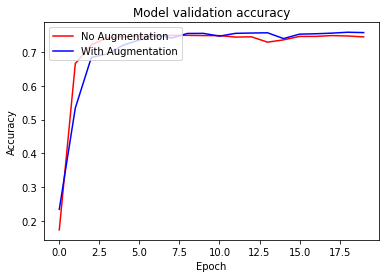

In [14]:
# 훈련과정 시각화

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

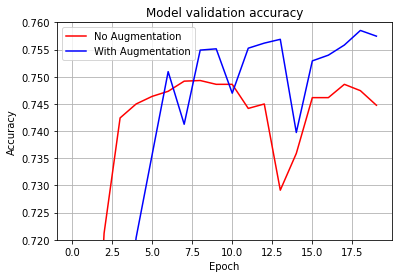

In [15]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

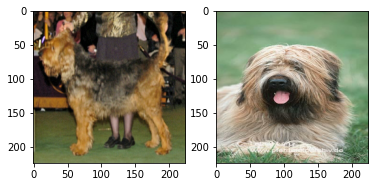

In [16]:
# CutMix 이미지 섞기

# 데이터 셋에서 2개의 이미지 가져오기

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [17]:
# 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때, 
# a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수 구현

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width // 2)
    ya = tf.math.maximum(0, y-height // 2)
    xb = tf.math.minimum(image_size_x, x+width // 2)
    yb = tf.math.minimum(image_size_y, y+width // 2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(65, shape=(), dtype=int32) tf.Tensor(88, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


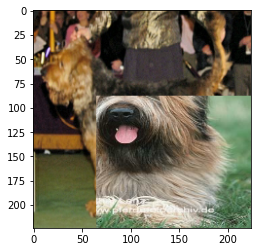

In [18]:
# 바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 
# 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수 구현

# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis = 1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis = 0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [19]:
# CutMix 라벨 섞기

# 섞인 이미지에 대해 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수 구현

# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa) * (yb-ya)
    total_area = image_size_x * image_size_y
    a = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.56903696,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [20]:
# 위에서 구현한 함수를 통해 배치 단위의 CutMix 함수 구현

def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_label

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.5529437 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.4470563 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

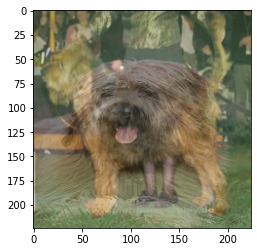

In [21]:
# MixUp Augmentation

# function for mixup

def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a) * image_a + a * image_b
    mixed_label = (1-a) * label_a + a * label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [22]:
# 배치단위의 MixUp 함수 구현

def mixup(image, label, prob = 1.0, batch_size = 16, img_size = 224, num_classes = 120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [23]:
# apply_normalize_on_dataset() : 다양한 형태로 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현하는 메인 함수

# 일반적인 전처리 과정 (normalize, resize, augmentation, shuffle 적용)
# shiffle, augmentation 은 테스트 데이터셋에는 적용하지 않아야 한다.


# 데이터셋을 가공하는 메인함수 (with_aug 매개변수를 통해 augmentation 적용 여부를 결정)

def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16, with_aug = False, with_cutmix = False, with_mixup = False):
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls = 2)
    
    if not is_test and with_aug:
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls = 2)
        
    elif not is_test and with_mixup : 
        ds = ds.map(mixup, num_parallel_calls = 2)
        Q
        
    else:
        ds = ds.map(onehot, num_parallel_calls = 2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [24]:
# onehot 인코딩

def onehot(image, label, num_classes = 120) : 
    label = tf.one_hot(label, num_classes)
    
    return image, label

In [25]:
# apply_normalize_on_dataset() : 다양한 형태로 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현하는 메인 함수

# 일반적인 전처리 과정 (normalize, resize, augmentation, shuffle 적용)
# shiffle, augmentation 은 테스트 데이터셋에는 적용하지 않아야 한다.


# 데이터셋을 가공하는 메인함수 (with_aug 매개변수를 통해 augmentation 적용 여부를 결정)

def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16, with_aug = False, with_cutmix = False, with_mixup = False):
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls = 2)
    
    if not is_test and with_aug:
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls = 2)
        
    elif not is_test and with_mixup : 
        ds = ds.map(mixup, num_parallel_calls = 2)
        
        
    else:
        ds = ds.map(onehot, num_parallel_calls = 2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

## 2. 모델 만들기
---

In [26]:
# Augumentation 을 적용한 데이터를 학습한 모델과 적용하지 않은 데이터를 학습한 모델의 성능 비교

# keras 의 ResNet50 중 imagenet 에 훈련도니 모델을 불러온다.
# include_top 은 마지막 fully connected layer 를 포함할지 여부
# 해당 레이어를 포함하지 않고 생성하면 feature extractor (특성 추출기) 부분만 불러와 
# 필요에 맞게 수정된 fully connected layer 를 붙여 활용 가능
# imagemet 과 테스트셋이 서로 다른 클래스를 가지기 때문에
# 마지막에 추가해야하는 fully connect layer 의 구조 (뉴런의 개수) 또한 다르다.

num_classes = ds_info.features['label'].num_classes

resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                       weights = 'imagenet', 
                                                                       input_shape = (224, 224, 3), 
                                                                       pooling = 'avg'), 
                                    keras.layers.Dense(num_classes, activation = 'softmax')])

In [27]:
# Augmentation + cutmix 을 적용한 데이터셋으로 학습시킬 ResNet 생성

aug_cm_resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                          weights = 'imagenet', 
                                                                          input_shape = (224, 224, 3), 
                                                                          pooling = 'avg'), 
                                       keras.layers.Dense(num_classes, activation = 'softmax')])

In [28]:
# Augmentation + mixup 을 적용한 데이터셋으로 학습시킬 ResNet 생성

aug_mu_resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                          weights = 'imagenet', 
                                                                          input_shape = (224, 224, 3), 
                                                                          pooling = 'avg'), 
                                       keras.layers.Dense(num_classes, activation = 'softmax')])

In [29]:
# 텐서플로우 데이터에서 불러온 데이터에 apply_normalize_on_dataset() 에
# 하나는 with_aug 를 False 로,
# 다른 하나는 with_aug 를 True 로 설정

(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', 
                                         split = ['train', 'test'], 
                                         as_supervised = True, 
                                         shuffle_files = True, 
                                         with_info = True)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug = False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_train_aug_cm = apply_normalize_on_dataset(ds_train, with_cutmix = True)
ds_train_aug_mu = apply_normalize_on_dataset(ds_train, with_mixup = True)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 3. 모델 훈련하기
---

In [30]:
# 모델 학습

EPOCH = 20

tf.random.set_seed(2020)
resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_cm_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_mu_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])


history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

history_resnet50_aug_cm = aug_cm_resnet50.fit(
    ds_train_aug, # augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

history_resnet50_aug_mu = aug_mu_resnet50.fit(
    ds_train_aug, # augmentation + mixup 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

Epoch 1/20
750/750 [==============================] - 336s 441ms/step - loss: 3.2159 - accuracy: 0.2779 - val_loss: 3.3174 - val_accuracy: 0.2094
Epoch 2/20
750/750 [==============================] - 331s 442ms/step - loss: 0.9255 - accuracy: 0.7414 - val_loss: 1.1286 - val_accuracy: 0.6666
Epoch 3/20
750/750 [==============================] - 331s 442ms/step - loss: 0.3299 - accuracy: 0.9211 - val_loss: 0.9661 - val_accuracy: 0.7205
Epoch 4/20
750/750 [==============================] - 331s 442ms/step - loss: 0.0901 - accuracy: 0.9903 - val_loss: 0.9351 - val_accuracy: 0.7311
Epoch 5/20
750/750 [==============================] - 331s 441ms/step - loss: 0.0314 - accuracy: 0.9985 - val_loss: 0.9331 - val_accuracy: 0.7369
Epoch 6/20
750/750 [==============================] - 331s 441ms/step - loss: 0.0182 - accuracy: 0.9992 - val_loss: 0.9355 - val_accuracy: 0.7420
Epoch 7/20
750/750 [==============================] - 331s 441ms/step - loss: 0.0131 - accuracy: 0.9994 - val_loss: 0.9517 -

## 4. 훈련 과정 시각화하기
---

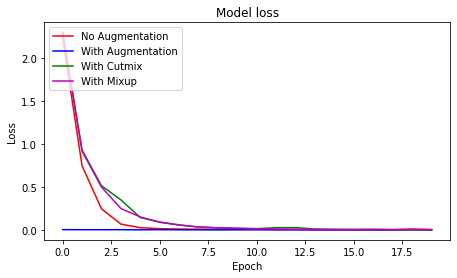

In [31]:
fig = plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cm.history['loss'], 'g')
plt.plot(history_resnet50_aug_mu.history['loss'], 'm')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

NameError: name 'history_resnet50_cutmix' is not defined

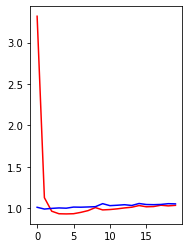

In [34]:
plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm')
plt.title('Model valication loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.show()

## 5. Augmentation에 의한 모델 성능 비교
---

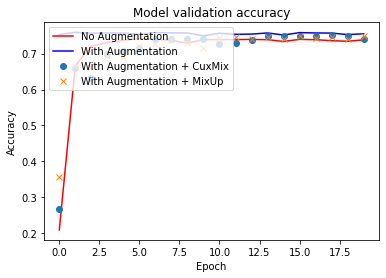

In [35]:
# 훈련과정 시각화

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cm.history['val_accuracy'], 'o')
plt.plot(history_resnet50_aug_mu.history['val_accuracy'], 'x')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + CuxMix', 'With Augmentation + MixUp'], loc='upper left')
plt.show()

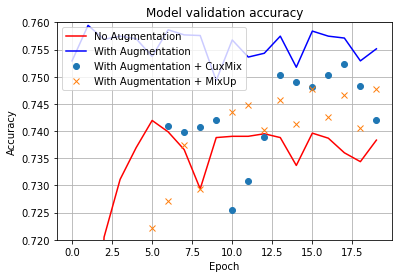

In [36]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cm.history['val_accuracy'], 'o')
plt.plot(history_resnet50_aug_mu.history['val_accuracy'], 'x')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + CuxMix', 'With Augmentation + MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

## 6. 회고

1. cutmix 와 mixup 의 경우 결과적으로 augmentation을 하지 않았을 때에 비해 정확도가 높아졌지만 만족스러운 정확도는 아니였다.
2. 오히려 일반적인 augmentaion을 적용했을 때의 정확도가 더 높게 나왔다.
3. epoch의 수가 부족했는지 아닌지 정확한 이유를 확인할 수 없었다.